In [1]:
from imports import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [4]:
timeseries = process_file()
len(timeseries)

62

In [5]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [115]:
# lookback window

lookback=1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)

X_train torch.Size([40, 1, 1]) y_train torch.Size([40, 1, 1])
X_test torch.Size([20, 1, 1]) y_test torch.Size([20, 1, 1])


#### Max abs scaler

In [116]:
from sklearn.preprocessing import MaxAbsScaler
scaler_x = MaxAbsScaler()
X_train = X_train.squeeze().numpy().reshape(-1, 1)
X_train = torch.tensor(scaler_x.fit_transform(X_train))

X_test = X_test.squeeze().numpy().reshape(-1, 1)
X_test = torch.tensor(scaler_x.transform(X_test))

# crear otro scaler
scaler_y = MaxAbsScaler()
y_train = y_train.squeeze().numpy().reshape(-1, 1)
y_train = torch.tensor(scaler_y.fit_transform(y_train))

y_test = y_test.squeeze().numpy().reshape(-1, 1)
y_test = torch.tensor(scaler_y.transform(y_test))

In [117]:
scaler_y


MaxAbsScaler()

#### Defining LSTM Model and hyperparameters

In [118]:
class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50,1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [119]:
model = LSTMModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

#### Training nnet

In [120]:
torch.manual_seed(42)
np.random.seed(42)

train_loss = []
train_rmse = []

n_epochs = 100
print_interval = 10

for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_rmse = 0.0
    num_samples = 0
    for X_batch, y_batch in loader:
        # forward pass
        y_pred = model(X_batch)

        # loss
        loss = loss_fn(y_pred, y_batch)
        epoch_train_loss += loss.item()

        # RMSE
        rmse = torch.sqrt(loss)
        epoch_train_rmse += rmse.item() ** 2
        num_samples += len(X_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      # RMSE en cada epoch
    epoch_train_rmse = np.sqrt(epoch_train_rmse / num_samples)

    if (epoch + 1) % print_interval == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f},  Train RMSE: {epoch_train_rmse:.4f}")
    
    train_loss.append(epoch_train_loss)
    train_rmse.append(epoch_train_rmse)


Epoch 10/100, Train Loss: 0.1869,  Train RMSE: 0.0817
Epoch 20/100, Train Loss: 0.1473,  Train RMSE: 0.0725
Epoch 30/100, Train Loss: 0.1235,  Train RMSE: 0.0664
Epoch 40/100, Train Loss: 0.1148,  Train RMSE: 0.0640
Epoch 50/100, Train Loss: 0.1279,  Train RMSE: 0.0676
Epoch 60/100, Train Loss: 0.0784,  Train RMSE: 0.0529
Epoch 70/100, Train Loss: 0.0686,  Train RMSE: 0.0495
Epoch 80/100, Train Loss: 0.1227,  Train RMSE: 0.0662
Epoch 90/100, Train Loss: 0.0735,  Train RMSE: 0.0512
Epoch 100/100, Train Loss: 0.1011,  Train RMSE: 0.0601


#### Evaluating on train and test

In [124]:
train_preds = []
train_loss = []
test_loss = []
test_rmse = []
gradient_norm = []
test_preds = []

model.eval()

# disable gradient computation
with torch.no_grad():
        epoch_test_loss = 0.0
        epoch_test_rmse = 0.0 
    
        y_pred_train = model(X_train[:len(train)])
        y_pred_train_unscaled = scaler_y.inverse_transform(y_pred_train.detach().numpy().reshape(-1,1))
        train_preds.append(y_pred_train_unscaled)

        # mas de 1 feature
        #train_loss.append(loss_fn(y_pred_train[:, 0], y_train).item())
        #train_rmse.append(np.sqrt(loss_fn(y_pred_train[:, 0], y_train).item()))

        train_loss.append(loss_fn(y_pred_train, y_train).item())
        train_rmse.append(np.sqrt(loss_fn(y_pred_train, y_train).item()))
    
        y_pred_test = model(X_test[:len(test)])
        y_pred_test_unscaled = scaler_y.inverse_transform(y_pred_test.detach().numpy().reshape(-1,1))
        test_preds.append(y_pred_test_unscaled)

        # mas de 1 feature
        #test_loss.append(loss_fn(y_pred_test[:, 0], y_test).item()) 
        #test_rmse.append(np.sqrt(loss_fn(y_pred_test[:, 0], y_test).item()))

        test_loss.append(loss_fn(y_pred_test, y_test).item())
        test_rmse.append(np.sqrt(loss_fn(y_pred_test, y_test).item()))
    

In [126]:
# creo un array concatenando las predicciones
train_array = np.concatenate([tensor.flatten() for tensor in train_preds])
test_array = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_array), len(test_array)

(40, 20)

In [127]:
max(train_array)

1674.4991

In [128]:
max(train_array)

1674.4991

#### Plotting results

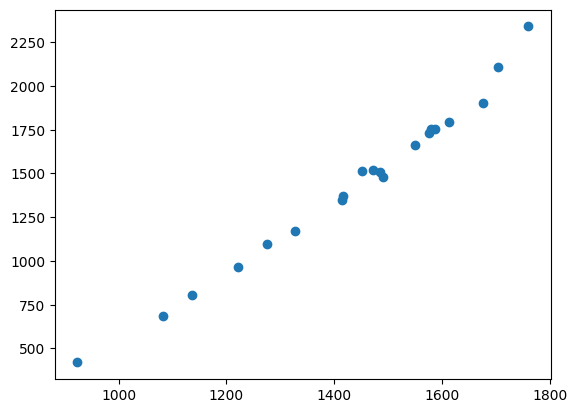

In [129]:
plt.scatter(test_array[:20], test[:20])

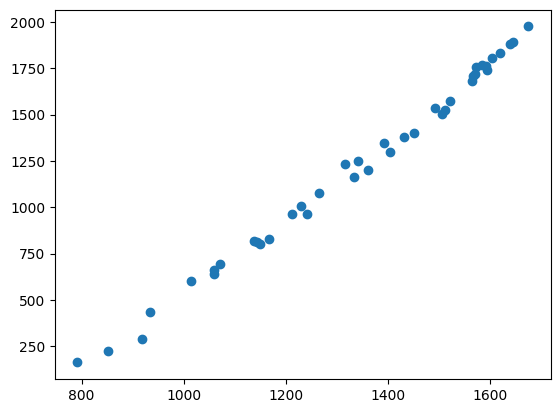

In [130]:
plt.scatter(train_array, train[:40])

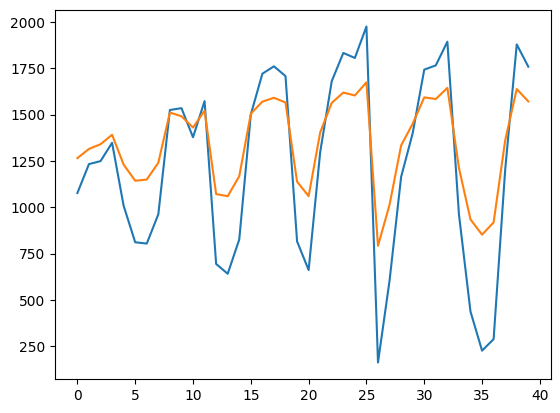

In [131]:
plt.plot(train[:40])
plt.plot(train_array)

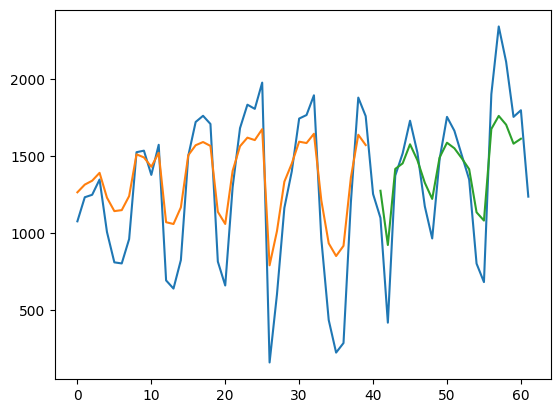

In [132]:
plt.plot(timeseries)
plt.plot(train_array)
plt.plot(range(41, 41+len(test_array)), test_array)

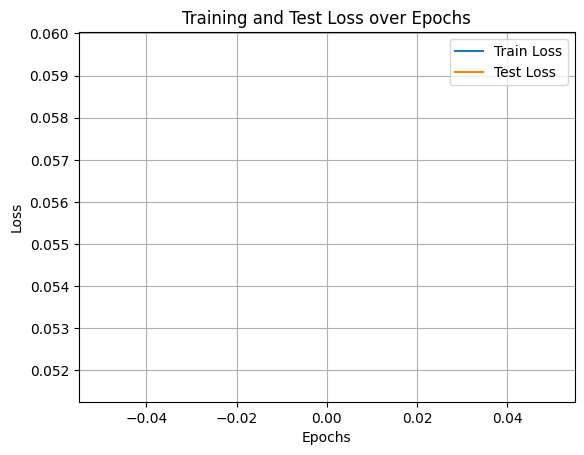

In [170]:
#epochs = range(0, n_epochs, 10)

#plt.plot(epochs, train_loss, label='Train Loss')
#plt.plot(epochs, test_loss, label='Test Loss')

plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')

plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()